**Using the mixup, label smoothing, cutout and test time augmentation on Cifar10 dataset**

In [ ]:
#pip install fastai --upgrade

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai libraries

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

Use untar_data function to load and extract data. Check *help(untar_data)* for more info

In [ ]:
path = untar_data(URLs.CIFAR); path

PosixPath('/root/.fastai/data/cifar10')

Check how data is located in folders

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/cifar10/train'),
 PosixPath('/root/.fastai/data/cifar10/labels.txt'),
 PosixPath('/root/.fastai/data/cifar10/models'),
 PosixPath('/root/.fastai/data/cifar10/test')]

Store locations on data in variables


In [ ]:
path_test = path/'test'
path_train = path/'train'

In [ ]:
path_train.ls()

[PosixPath('/root/.fastai/data/cifar10/train/truck'),
 PosixPath('/root/.fastai/data/cifar10/train/ship'),
 PosixPath('/root/.fastai/data/cifar10/train/bird'),
 PosixPath('/root/.fastai/data/cifar10/train/dog'),
 PosixPath('/root/.fastai/data/cifar10/train/automobile'),
 PosixPath('/root/.fastai/data/cifar10/train/airplane'),
 PosixPath('/root/.fastai/data/cifar10/train/cat'),
 PosixPath('/root/.fastai/data/cifar10/train/deer'),
 PosixPath('/root/.fastai/data/cifar10/train/frog'),
 PosixPath('/root/.fastai/data/cifar10/train/horse')]

Create an object ImageDataBunch. It represents all of the data we need to build a model 

In [ ]:
data = ImageDataBunch.from_folder(path=path, train='train', valid='test', size=32, bs=bs, ds_tfms=get_transforms(), num_workers=0).normalize(imagenet_stats)


Check the data

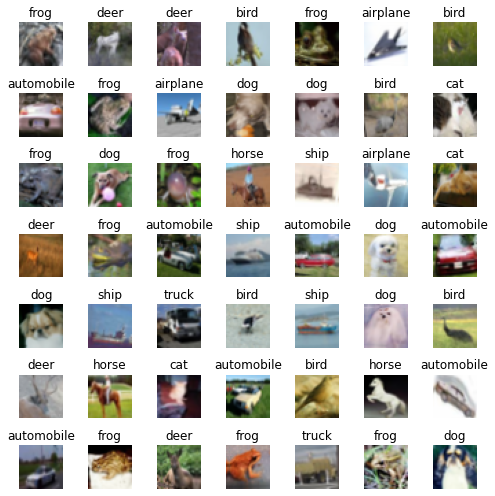

In [ ]:
data.show_batch(rows=7, figsize=(7,7))

Check our classes

In [ ]:
print(data.classes)
len(data.classes),data.c

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(10, 10)

Train with ResNet50

In [ ]:
data = ImageDataBunch.from_folder(path=path, train='train', valid='test', size=32, bs=bs, ds_tfms=get_transforms(), num_workers=0).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
#learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


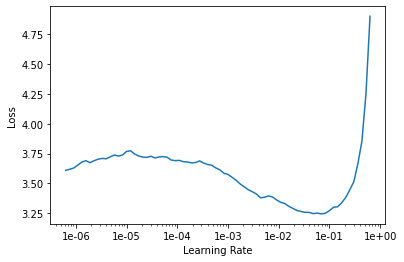

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.616261,1.255523,0.439500,02:05
1,1.082808,0.996821,0.344300,02:05
2,0.909502,0.798005,0.277400,02:03
3,0.827864,0.721640,0.257100,02:03
4,0.765238,0.702670,0.248300,02:00


# Check Results

Check where the model was confused

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

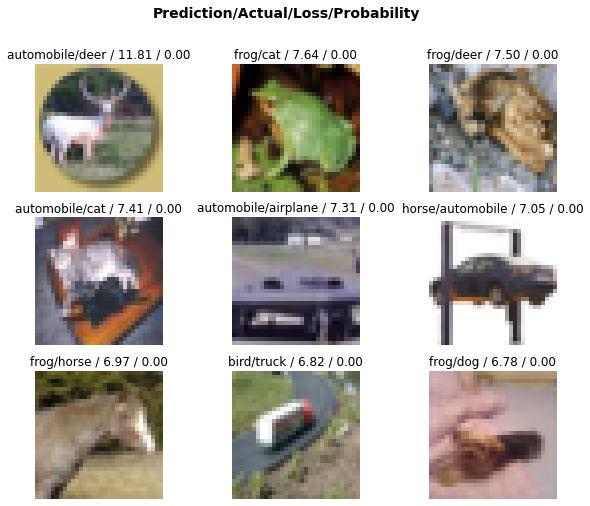

In [ ]:
interp.plot_top_losses(9, figsize=(10,8))

confusion matrix

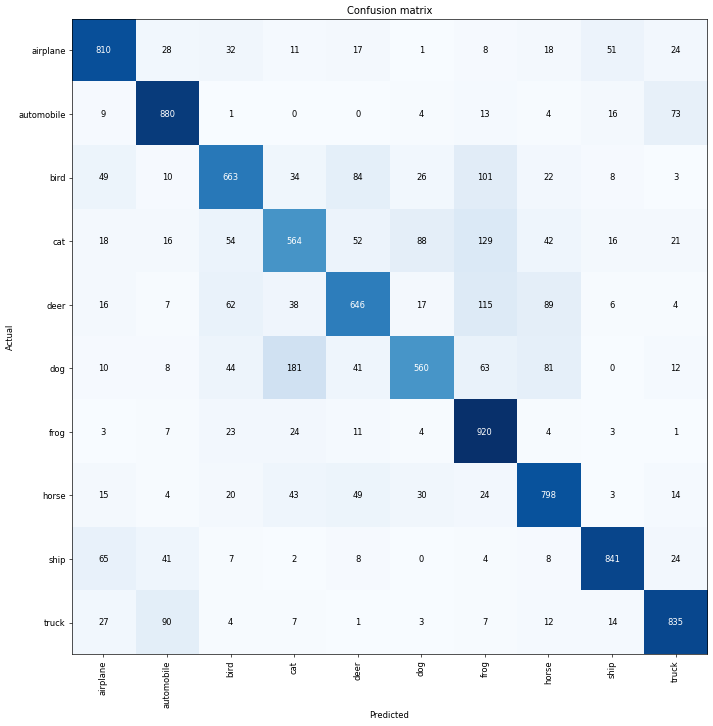

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

**Try test time augmentation**

In [ ]:
preds, targs = learn.TTA()

In [ ]:
accuracy(preds, targs).item()

0.7875000238418579

**MixUp augmentation**

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate).to_fp16().mixup()
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.928830,1.644717,0.475800,02:15
1,1.504844,1.136497,0.350600,02:15
2,1.375921,0.892560,0.294400,02:14
3,1.292709,0.782840,0.267100,02:17
4,1.279047,0.788108,0.269700,02:16


**Adding Label Smoothing**

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, loss_func=LabelSmoothingCrossEntropy())
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,2.064370,3.172123,0.485500,02:17
1,1.664046,1.272980,0.336000,02:15
2,1.575830,1.198070,0.304700,02:14
3,1.528373,1.158922,0.275200,02:10
4,1.475668,1.109558,0.262900,02:12


**Cutout transformation**

In [ ]:
tfms_cutout = [cutout(n_holes=(1,4), length=(5, 16), p=.5)]
tfms = get_transforms(xtra_tfms=tfms_cutout)
data = ImageDataBunch.from_folder(path=path, train='train', valid='test', size=32, bs=bs, ds_tfms=tfms, num_workers=0).normalize(imagenet_stats)

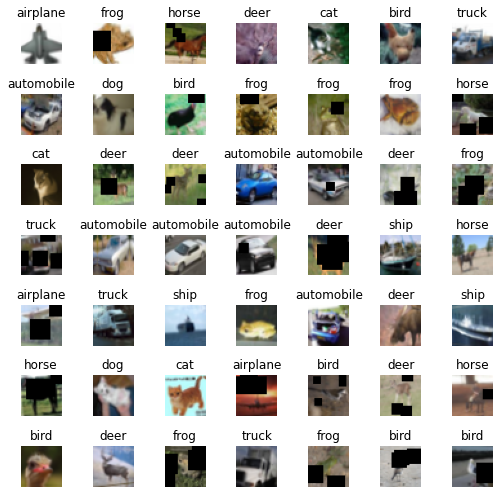

In [ ]:
data.show_batch(rows=7, figsize=(7,7))